Import Libraries


In [6]:
import pandas as pd
import numpy as np

import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from statistics import mean, stdev

import seaborn as sns

from unicodedata import normalize

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import VotingClassifier


import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



In [7]:
def test_setup():
    print("running test setup")
    trainingSet = pd.read_csv("./data/train.csv")
    testingSet = pd.read_csv("./data/test.csv")

    print("train.csv shape is ", trainingSet.shape)
    print("test.csv shape is ", testingSet.shape)

    print()

    print(trainingSet.head())
    print()
    print(testingSet.head())

    print()

    print(trainingSet.describe())

    trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
    plt.show()

    print()
    print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")
    return


In [8]:
 # test_setup()

In [9]:
# https://gist.github.com/jbencina/03b2673a6fc27e2717650686b379eeca

In [17]:

# Load the dataset
df = pd.read_csv("./data/train.csv")
# full_training = pd.read_csv("./data/train.csv")
# df = pd.DataFrame(full_training.sample(500000))

# df= df_full.sample(100000)


In [18]:
# This is where you can do all your processing
print("Joining and Removing Features")
df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['Helpfulness'] = df['Helpfulness'].fillna(0)

df['Text'] = df['Summary']+ ' ' +df['Text'] # combine text fields 
df['Raw_text'] = df['Text']
df['Review_len'] = df["Text"].str.len() # review length
df.drop('HelpfulnessDenominator', axis=1, inplace=True) # remove denominator field
df.drop('HelpfulnessNumerator', axis=1, inplace=True) # remove nominator field
df.drop('Summary', axis=1, inplace=True) # remove summary 
# df = df.dropna(subset=['Text']) # remove any empty text fields 
df.Text = df.Text.fillna('fill') # instead of getting rid of no text fields, fill with word "fill"
df.Raw_text = df.Raw_text.fillna('fill') # instead of getting rid of no text fields, fill with word "fil"

Joining and Removing Features


In [19]:
# Add time review was posted 
# Month may not add much infor

df['Date'] = pd.to_datetime(df['Time'], unit='s')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

df.drop('Date', axis=1, inplace=True) # remove date field
df.drop('Time', axis=1, inplace=True) # remove Time field
# df.drop('Month', axis=1, inplace=True) # remove Month field

In [20]:
print("Binning Years")
df['Year_bin'] = df['Year'].astype(int)
df.loc[ df['Year'] <= 1998, 'Year_bin'] = 0 #0
df.loc[(df['Year'] > 1998) & (df['Year'] <= 2000), 'Year_bin'] = 1 # 0
df.loc[(df['Year'] > 2000) & (df['Year'] <= 2002), 'Year_bin'] = 2 # 1
df.loc[(df['Year'] > 2002) & (df['Year'] <= 2004), 'Year_bin'] = 3 # 1
df.loc[(df['Year'] > 2004) & (df['Year'] <= 2006), 'Year_bin'] = 4 # 2
df.loc[(df['Year'] > 2006) & (df['Year'] <= 2008), 'Year_bin'] = 5 # 2
df.loc[(df['Year'] > 2008) & (df['Year'] <= 2010), 'Year_bin'] = 6 # 2
df.loc[(df['Year'] > 2010) & (df['Year'] <= 2012), 'Year_bin'] = 7 # 3
df.loc[(df['Year'] > 2012) & (df['Year'] <= 2014), 'Year_bin'] = 8 # 3

Binning Years


In [21]:
print("downloading nltk")
# download nltk tools
nltk.download([
"names",
"stopwords",
"averaged_perceptron_tagger",
"wordnet",
'omw-1.4',
"vader_lexicon",
"punkt",])
 

downloading nltk


[nltk_data] Downloading package names to
[nltk_data]     /usr4/ugrad/arnaudh/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr4/ugrad/arnaudh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr4/ugrad/arnaudh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr4/ugrad/arnaudh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /usr4/ugrad/arnaudh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr4/ugrad/arnaudh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /usr

True

In [22]:
print("Processing Text Data")
# remove any non A-Z characters in review text
regex = re.compile('[^a-zA-Z]')
df['Text'] = df['Text'].apply(lambda x: regex.sub(" ", x))
# df = df.dropna(subset=['Text']) # remove any empty text fields

Processing Text Data


In [ ]:
print("Removing Stopwords")
# function for removing all stopwords from a piece of text 
stopwords=nltk.corpus.stopwords.words("english")
def rem_stopw(words):
    words = [w for w in words if w.lower() not in stopwords]
    return words

#remove stopwords from the text in df 
df['Text'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))
df['Text'] = df['Text'].apply(lambda x: rem_stopw(x)) #remove stopwords

Removing Stopwords


In [ ]:
# re-join the tokenized texrt so that VADER can work properly
df['Text'] = df['Text'].apply(lambda x:" ".join(x))

In [ ]:
#SIA works on raw text, not anything tokenized, hence the above operation
print("Performing Sentiment Analysis")
sia = SentimentIntensityAnalyzer()
def sentiment(text):
    scores = []
    #all_scores = []
    for sentence in nltk.sent_tokenize(text):
        scores.append(sia.polarity_scores(sentence)["compound"])
        #all_scores.append(sia.polarity_scores(sentence))
    try:
        scores = mean(scores)
    except:
        scores = np.nan
    
    return scores

# add sentiment score to dataframe
df['Sentiment'] = df['Text'].apply(lambda x: sentiment(x))

In [ ]:
# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(df, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  df[df['Score'].notnull()]

testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

In [ ]:
testX.shape

In [ ]:
trainX.shape

######################################################################################################################

################################################### MODELS ###########################################################

<AxesSubplot:xlabel='Score', ylabel='Sentiment'>

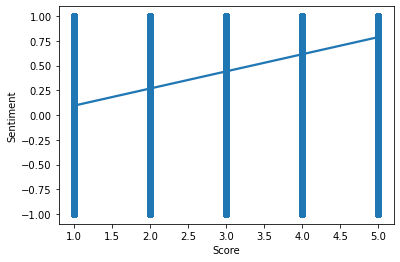

In [19]:
sns.regplot(x=trainX["Score"], y=trainX["Sentiment"])

In [ ]:
trainX['Text']= trainX['Text'].fillna('fill')
trainX['Raw_text']= trainX['Raw_text'].fillna('fill')
trainX['Review_len']=trainX['Review_len'].fillna(1)

In [ ]:
testX['Text'] = testX['Text'].fillna('fill')
testX['Raw_text']= testX['Raw_text'].fillna('fill')
testX['Review_len']=testX['Review_len'].fillna(1)

In [ ]:
X_submission = testX

In [ ]:
X_submission['Text']= X_submission['Text'].fillna('fill')
X_submission['Raw_text']= X_submission['Raw_text'].fillna('fill')
X_submission['Review_len']=X_submission['Review_len'].fillna(1)

In [ ]:
# Load files into DataFrames
#X_train = pd.read_csv("./data/X_train.csv")

X_train = trainX


# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed =  X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text'])
X_submission_processed = X_submission.drop(columns=[
    'Id', 'ProductId', 'UserId', 'Score', 'Text'])
# X_submission_processed = X_test_processed

In [ ]:
X_train_words = pd.DataFrame(X_train_processed['Raw_text'])
X_train_words = X_train_words[X_train_words['Raw_text'].notna()]

In [ ]:
# Apply pipeline union 

In [ ]:
get_text_data = FunctionTransformer(lambda x: x['Raw_text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x:
                                       x[['Helpfulness',
                                         'Review_len',
                                         'Month',
                                         'Year_bin',
                                         'Sentiment',
                                         ]], validate=False)

In [ ]:
process_and_join_features = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                 ('vec', CountVectorizer(ngram_range=(1,3)))
            ]))
         ])),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
])

In [ ]:
_ = process_and_join_features.fit(X_train_processed, Y_train)

pred_joined = process_and_join_features.predict(X_test_processed)

print("LogReg Accuracy: ", np.mean(pred_joined == Y_test))

In [ ]:
X_submission['Score'] = process_and_join_features.predict(X_test_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)